# HeatMapWithTime for UCDP data
[Stack Overflow Link](https://stackoverflow.com/questions/64325958/heatmapwithtime-plugin-in-folium/64392033#64392033https://stackoverflow.com/questions/64325958/heatmapwithtime-plugin-in-folium/64392033#64392033)

In [71]:
import geopandas as gpd
from collections import defaultdict, OrderedDict
import pandas as pd
import folium
import folium.plugins as plugins
from folium import Choropleth, Circle, Marker
from folium.plugins import HeatMap, MarkerCluster, HeatMapWithTime
import os
import gdal
from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np
import math

In [72]:
# Country and governorate polygon shapefiles
c_borders = gpd.read_file('shapes/Countries.shp').boundary
g_borders= gpd.read_file('shapes/Governorates.shp').boundary
idp_camps = pd.read_csv('shapes/IDPs.csv')
refugee_camps = pd.read_csv('shapes/Refugees.csv')

In [73]:
# UCDP data with 225,385 events (81,707 from the Middle East)
ucdp_df = pd.read_csv('csv/ged201.csv', low_memory=False)
pd.crosstab(ucdp_df[ucdp_df["region"] == "Middle East"]["year"],ucdp_df[ucdp_df["region"] == "Middle East"]["country"], margins=True)

country,Bahrain,Egypt,Iran,Iraq,Israel,Jordan,Kuwait,Lebanon,Qatar,Saudi Arabia,Syria,Turkey,United Arab Emirates,Yemen (North Yemen),All
year,,,,,,,,,,,,,,,
1989,0,0,0,2,58,0,0,210,0,0,0,63,0,0,333
1990,0,2,14,6,37,0,19,89,0,0,0,69,0,0,236
1991,0,0,3,87,37,0,19,29,0,4,0,134,0,0,313
1992,0,5,2,48,55,1,0,54,0,0,0,329,0,0,494
1993,0,43,17,38,61,0,0,80,0,0,0,482,0,0,721
1994,0,76,2,31,52,0,0,59,0,0,0,613,0,72,905
1995,0,118,3,58,24,0,0,71,0,0,0,524,0,0,798
1996,0,75,4,52,25,0,1,57,0,0,0,335,0,0,549
1997,0,34,13,31,5,0,0,60,0,0,0,271,0,0,414


In [74]:
ucdp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225385 entries, 0 to 225384
Data columns (total 49 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 225385 non-null  int64  
 1   relid              225385 non-null  object 
 2   year               225385 non-null  int64  
 3   active_year        225385 non-null  int64  
 4   code_status        225385 non-null  object 
 5   type_of_violence   225385 non-null  int64  
 6   conflict_dset_id   225385 non-null  int64  
 7   conflict_new_id    225385 non-null  int64  
 8   conflict_name      225385 non-null  object 
 9   dyad_dset_id       225385 non-null  int64  
 10  dyad_new_id        225385 non-null  int64  
 11  dyad_name          225385 non-null  object 
 12  side_a_dset_id     225385 non-null  int64  
 13  side_a_new_id      225385 non-null  int64  
 14  side_a             225385 non-null  object 
 15  side_b_dset_id     225385 non-null  int64  
 16  si

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

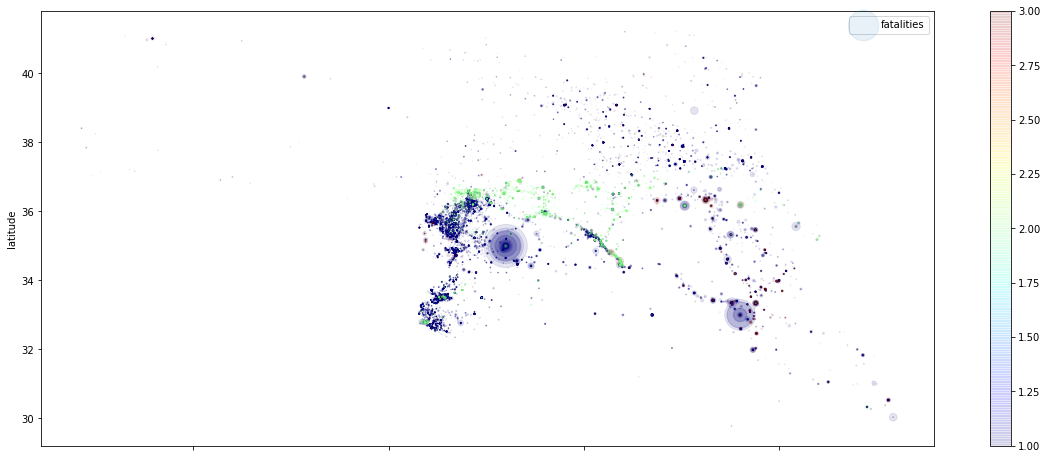

In [75]:
threeCountries = ucdp_df[(ucdp_df["country"]=="Syria") | (ucdp_df["country"]=="Turkey") | (ucdp_df["country"]=="Iraq")]
threeCountries.plot(kind="scatter", x="longitude", y ="latitude", alpha=.1, 
             s=threeCountries["best"]/10, label="fatalities", 
             c=threeCountries["type_of_violence"], cmap=plt.get_cmap("jet"), colorbar=True,
             figsize=(20,8))

In [76]:
ucdp_df.corr()

,id,year,active_year,type_of_violence,conflict_dset_id,conflict_new_id,dyad_dset_id,dyad_new_id,side_a_dset_id,side_a_new_id,...,event_clarity,date_prec,deaths_a,deaths_b,deaths_civilians,deaths_unknown,best,high,low,gwnob
id,1.000000,0.592966,0.091362,-0.187717,0.182980,0.185037,0.558717,0.558037,0.060451,0.060451,...,-0.035318,-0.104262,-0.012293,-0.011327,-0.001387,-0.011783,-0.012054,-0.007720,-0.019490,0.169959
year,0.592966,1.000000,0.073342,-0.168430,0.258596,0.263029,0.481361,0.482868,0.104808,0.104808,...,-0.023503,-0.106386,-0.017000,-0.012042,-0.028350,-0.013465,-0.035370,-0.046216,-0.030757,0.323797
active_year,0.091362,0.073342,1.000000,-0.178901,-0.022458,-0.029799,0.062655,0.050920,-0.048605,-0.048605,...,0.015593,-0.032042,0.005077,0.012538,0.003575,0.002681,0.007263,0.006803,0.007542,-0.088137
type_of_violence,-0.187717,-0.168430,-0.178901,1.000000,0.119062,0.158386,-0.193399,-0.126181,0.289631,0.289631,...,-0.023561,0.116943,-0.014590,-0.037536,0.039399,-0.002465,0.020508,0.035476,0.010305,NaN
conflict_dset_id,0.182980,0.258596,-0.022458,0.119062,1.000000,0.984419,0.569465,0.574100,0.453377,0.453377,...,0.023118,0.043079,0.000317,0.000948,-0.007517,0.003478,-0.003851,-0.007486,-0.001994,-0.139621
conflict_new_id,0.185037,0.263029,-0.029799,0.158386,0.984419,1.000000,0.551565,0.579975,0.502839,0.502839,...,0.021096,0.047069,-0.000432,-0.000602,-0.005851,0.002689,-0.003371,-0.006520,-0.001962,-0.139621
dyad_dset_id,0.558717,0.481361,0.062655,-0.193399,0.569465,0.551565,1.000000,0.989721,0.216503,0.216503,...,-0.087437,-0.087806,0.001818,-0.011797,-0.014155,-0.002290,-0.013398,-0.019480,-0.010563,-0.161633
dyad_new_id,0.558037,0.482868,0.050920,-0.126181,0.574100,0.579975,0.989721,1.000000,0.280653,0.280653,...,-0.089413,-0.079945,0.000757,-0.014472,-0.011843,-0.002777,-0.012492,-0.017815,-0.010264,-0.161633
side_a_dset_id,0.060451,0.104808,-0.048605,0.289631,0.453377,0.502839,0.216503,0.280653,1.000000,1.000000,...,0.010440,0.045176,-0.003097,-0.007991,-0.001051,0.002680,-0.001342,-0.002980,-0.000302,-0.156783
side_a_new_id,0.060451,0.104808,-0.048605,0.289631,0.453377,0.502839,0.216503,0.280653,1.000000,1.000000,...,0.010440,0.045176,-0.003097,-0.007991,-0.001051,0.002680,-0.001342,-0.002980,-0.000302,-0.156783


In [77]:
# 2017: 13,072 events
# 2009: 6,626 events
ucdp_df[(ucdp_df["year"] == 2017) | (ucdp_df["year"] == 2009) ]["year"].value_counts()

2017    13072
2009     6626
Name: year, dtype: int64

In [78]:
data = defaultdict(list)

In [79]:
for r in ucdp_df.itertuples():
    data[r.year].append([r.latitude, r.longitude])

In [80]:
# sort by year
data = OrderedDict(sorted(data.items(), key=lambda t: t[0]))

In [81]:
print('2017:',len(data[2017]), 'events')
print('2009:',len(data[2009]), 'events')

2017: 13072 events
2009: 6626 events


In [82]:
list(data.keys())

[1989,
 1990,
 1991,
 1992,
 1993,
 1994,
 1995,
 1996,
 1997,
 1998,
 1999,
 2000,
 2001,
 2002,
 2003,
 2004,
 2005,
 2006,
 2007,
 2008,
 2009,
 2010,
 2011,
 2012,
 2013,
 2014,
 2015,
 2016,
 2017,
 2018,
 2019]

## combined.tif layer 

In [83]:
background = os.path.join(os.path.expanduser('~'), 'Dropbox/MENA/_Land use/Javier Parada/results/pixel','geotiff', 'combined.tif')
print(background)

/Users/javierparada/Dropbox/MENA/_Land use/Javier Parada/results/pixel/geotiff/combined.tif


In [84]:
ds = gdal.Open(background) 
if ds is None:
    print('Could not open')

In [85]:
print("Driver: {}/{}".format(ds.GetDriver().ShortName,
                            ds.GetDriver().LongName))
print("Size is {} x {} x {}".format(ds.RasterXSize,
                                    ds.RasterYSize,
                                    ds.RasterCount))
print("Projection is {}".format(ds.GetProjection()))
geotransform = ds.GetGeoTransform()
if geotransform:
    print("Origin = ({}, {})".format(geotransform[0], geotransform[3]))
    print("Pixel Size = ({}, {})".format(geotransform[1], geotransform[5]))
          

Driver: GTiff/GeoTIFF
Size is 5110 x 2905 x 1
Projection is GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]
Origin = (25.660376091, 42.108528943)
Pixel Size = (0.004491576420547945, -0.004491576420654045)


In [86]:
band = ds.GetRasterBand(1)
print("Band Type={}".format(gdal.GetDataTypeName(band.DataType)))

min = band.GetMinimum()
max = band.GetMaximum()
if not min or not max:
    (min,max) = band.ComputeRasterMinMax(True)
print("Min={:.3f}, Max={:.3f}".format(min,max))

if band.GetOverviewCount() > 0:
    print("Band has {} overviews".format(band.GetOverviewCount()))

if band.GetRasterColorTable():
    print("Band has a color table with {} entries".format(band.GetRasterColorTable().GetCount()))

Band Type=Byte
Min=0.000, Max=8.000


In [87]:
raster = band.ReadAsArray()
raster

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [88]:
#Get coordinates, cols and rows
geotransform = ds.GetGeoTransform()
cols = ds.RasterXSize 
rows = ds.RasterYSize 
print(cols, 'columns')
print(rows, 'rows')
print((rows)*(cols), 'pixels')
# Should it be 14,893,434 ?

5110 columns
2905 rows
14844550 pixels


In [89]:
geotransform

(25.660376091,
 0.004491576420547945,
 0.0,
 42.108528943,
 0.0,
 -0.004491576420654045)

In [90]:
#Get extent
xmin=geotransform[0]
ymax=geotransform[3]
xmax=xmin+cols*geotransform[1]
ymin=ymax+rows*geotransform[5]

#Get Central point
centerx=(xmin+xmax)/2
centery=(ymin+ymax)/2
print('Center x:', centerx)
print('Center y:', centery)

Center x: 37.136353845500004
Center y: 35.584514192


In [91]:
#Raster convert to array in numpy
bands = ds.RasterCount
band=ds.GetRasterBand(1)
dataset= band.ReadAsArray(0,0,cols,rows)
dataimage=dataset
dataimage[dataimage[:,:]==-340282346638528859811704183484516925440.000]=0

In [92]:
bands

1

In [93]:
dataimage

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [94]:
unique_elements, counts_elements = np.unique(dataimage, return_counts=True)
print(np.asarray((unique_elements, counts_elements)))

[[      0       1       2       3       4       5       6       7       8]
 [7286715    2114      30    1944 5914637  135524     121  120369 1383096]]


In [95]:
print([ymin, xmin], [ymax, xmax])

[29.060499441, 25.660376091] [42.108528943, 48.612331600000005]


In [96]:
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

In [97]:
colors = {0:'blue', 1:'blue', 2:'blue', 3:'blue', 4:'white', 5:'black', 6:'blue', 7:'red', 8:'green'}
values = [0, 1, 2, 3, 4, 5, 6, 7, 8]
for x in values:
    print(0 if x==0 else 0 if x==1 else 0 if x==2 else 0 if x==3 else 255 if x==4 else 0 if x==5 else 0 if x==6 else 200 if x==7 else 0,
          100 if x==0 else 100 if x==1 else 100 if x==2 else 100 if x==3 else 255 if x==4 else 50 if x==5 else 100 if x==6 else 0 if x==7 else 200,
          255 if x==0 else 255 if x==1 else 255 if x==2 else 255 if x==3 else 255 if x==4 else 0 if x==5 else 255 if x==6 else 0 if x==7 else 0)

0 100 255
0 100 255
0 100 255
0 100 255
255 255 255
0 50 0
0 100 255
200 0 0
0 200 0


# Map

In [100]:
# Leaflet’s CRS: EPSG3857 
# colormap= lambda x: (1, 0, 1, 1) #R,G,B,alpha,
# tiles='stamentoner',
# play with z-index
# m.keep_in_front(m.add_child(hm)

# Basemap
m = folium.Map([35, 41], tiles='stamentoner', zoom_start=6)

colors = {0:'blue', 1:'blue', 2:'blue', 3:'blue', 4:'white', 5:'black', 6:'blue', 7:'red', 8:'green'}

# Polygons
syria = Choropleth(geo_data=c_borders, name="Countries",show=False).add_to(m)
governorates = Choropleth(geo_data=g_borders, name="Governorates",show=False).add_to(m)

for each in refugee_camps.iterrows():
    folium.Marker(location = [each[1]['Latitude'],each[1]['Longitude']],
                  popup = "<b>" + each[1]['Name'] + "</b>" + "\n Refugee Camp in "+ each[1]['AdministrativeDivision']+", "+each[1]['Country'],
                  icon=folium.Icon(color='blue',icon='home',prefix='fa'),
                  clustered_marker = True).add_to(m)

for each in idp_camps.iterrows():
    folium.Marker(location = [each[1]['Latitude'],each[1]['Longitude']],
                  popup = "<b>" + each[1]['Name'] + "</b>" + "\n IDP Camp in "+ each[1]['ADM1']+", "+each[1]['Country'],
                  icon=folium.Icon(color='purple',icon='home',prefix='fa'),
                  clustered_marker = True).add_to(m)
    
osm = folium.TileLayer(tiles="OpenStreetMap").add_to(m)
terrain = folium.TileLayer(tiles="stamenterrain").add_to(m)

               
# Satellite image
tile = folium.TileLayer(
        tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
        attr = 'Esri',
        name = 'Esri Satellite',
        overlay = False,
        control = True).add_to(m)

# Land Use Changes
folium.raster_layers.ImageOverlay(
    image=dataimage,
    bounds=[[ymin, xmin], [ymax, xmax]],
    colormap = lambda x: (0 if x==0 else 0 if x==1 else 0 if x==2 else 0 if x==3 else 255 if x==4 else 0 if x==5 else 0 if x==6 else 200 if x==7 else 0,
          100 if x==0 else 100 if x==1 else 100 if x==2 else 100 if x==3 else 255 if x==4 else 50 if x==5 else 100 if x==6 else 0 if x==7 else 200,
          255 if x==0 else 255 if x==1 else 255 if x==2 else 255 if x==3 else 255 if x==4 else 0 if x==5 else 255 if x==6 else 0 if x==7 else 0,1),
    name= 'MODIS Transitions 2009 vs. 2017',
    opacity=.8,
    zindex=1,
    overlay=False,
    mercator_project=True).add_to(m)

# UCDP HeatMap
hm = HeatMapWithTime(data=list(data.values()), # coordinates
                     index=list(data.keys()), # years 
                     name = 'UCDP events',
                     radius=10,
                     auto_play=False,
                     max_opacity=1).add_to(m)
loc = 'Land Use Change induced by Conflict and Displacement along the Syria-Turkey border'
title_html = '''
             <h3 align="center" style="font-size:16px"><b>{}</b></h3>
             '''.format(loc)  
m.get_root().html.add_child(folium.Element(title_html))
folium.LayerControl().add_to(m)
m.save('html/index.html')

In [39]:
refugee_camps

,Country,Designation,AdministrativeDivision,Name,Latitude,Longitude,fips,iso_alpha2,iso_alpha3,iso_num,stanag,tld,GENC2
0,Iraq,Official Camp Open,Al Anbar,Al Obaidy,34.418000,41.221000,IZ,IQ,IRQ,368,IRQ,.iq,IQ
1,Iraq,Official Camp Open,As Sulaymaniyah,Arbat Camp,35.375216,45.610139,IZ,IQ,IRQ,368,IRQ,.iq,IQ
2,Iraq,Official Camp Open,Erbil,Basirma,36.498000,44.340000,IZ,IQ,IRQ,368,IRQ,.iq,IQ
3,Iraq,Official Camp Open,Erbil,Darashakran,36.470000,43.889000,IZ,IQ,IRQ,368,IRQ,.iq,IQ
4,Iraq,Official Camp Open,Dahuk,Domiz 1,36.780000,42.880000,IZ,IQ,IRQ,368,IRQ,.iq,IQ
5,Iraq,Official Camp Open,Dahuk,Domiz 2,36.763926,42.895752,IZ,IQ,IRQ,368,IRQ,.iq,IQ
6,Iraq,Official Camp Open,Ninawa,Gawilan,36.343000,43.608000,IZ,IQ,IRQ,368,IRQ,.iq,IQ
7,Iraq,Official Camp Open,Erbil,Kawergosk,36.344000,43.814000,IZ,IQ,IRQ,368,IRQ,.iq,IQ
8,Iraq,Official Camp Open,Erbil,Qushtapa,35.983000,44.038000,IZ,IQ,IRQ,368,IRQ,.iq,IQ
9,Iraq,Transitional Facility Open,Ninawa,Akre,36.736000,43.879000,IZ,IQ,IRQ,368,IRQ,.iq,IQ


In [38]:
idp_camps

,Description,Country,ADM1,ADM2,ADM3,ADM4,Latitude,Longitude,Name,PCODE,fips,iso_alpha2,iso_alpha3,stanag,tld,GENC2
0,IDP Camp,Syria,Al Qunaytirah,Al Qunaytirah,Al Qunaytirah,Breiqa,33.039,35.860,Burayqah IDP Camp,SY140000C6269,SY,SY,SYR,SYR,.sy,SY
1,IDP Camp,Syria,As Suwayda',As Suwayda',As Suwayda',Kherba,32.583,36.439,Kharaba IDP Camp,SY130000C6150,SY,SY,SYR,SYR,.sy,SY
2,IDP Camp,Syria,As Suwayda',As Suwayda',As Suwayda',Kherba,32.588,36.447,Kharaba Church East IDP Camp,SY130000C6150,SY,SY,SYR,SYR,.sy,SY
3,IDP Camp,Syria,Damascus Countryside,Duma,Sabe Byar,Sabe Byar,33.311,38.674,Ruqban Border Crossing IDP Camp,SY030202C2345,SY,SY,SYR,SYR,.sy,SY
4,IDP Camp,Syria,Damascus Countryside,Duma,Sabe Byar,Sabe Byar,32.857,37.820,Khashm al Ghardush IDP Camp,SY030202C2345,SY,SY,SYR,SYR,.sy,SY
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,IDP Camp,Syria,Latakia,Latakia,Rebee'a,Samira - Sallur,35.857,36.111,Qarah Bibar IDP Camp,SY060002C3501,SY,SY,SYR,SYR,.sy,SY
72,IDP Camp,Syria,Tartus,Tartus,Tartus,Ennabiya,34.851,35.907,Shirkat as Sahil IDP Camp,SY100000C5238,SY,SY,SYR,SYR,.sy,SY
73,IDP Camp,Syria,Tartus,Tartus,Tartus,Ennabiya,34.858,35.893,Hayy ar Radar IDP Camp,SY100000C5238,SY,SY,SYR,SYR,.sy,SY
74,IDP Camp,Syria,Tartus,Tartus,Tartus,Hisheh,34.787,35.926,Al Hishah IDP Camp,SY100000C5243,SY,SY,SYR,SYR,.sy,SY


In [ ]:
# Tootltip
https://gis.stackexchange.com/questions/257958/line-break-in-a-popup-box-in-leaflet

In [ ]:
#<style>.leaflet-heatmap-layer{z-index:300 !important}</style>

# Notes: 

In [ ]:
heat_map_031108011189466cad5f020d6c9c7f89

# img = folium.raster_layers.ImageOverlay(
        name='MODIS',
        image=merc,
        bounds=[[-82, -180], [82, 180]],
        opacity=0.6,
        interactive=True,
        cross_origin=False,
        zindex=1,
    ).add_to(m)

title_html = '''
             <h3 align="center" style="font-size:20px"><b>Uppsala Conflict Data Program Heat Map</b></h3>
             '''
m.get_root().html.add_child(folium.Element(title_html))

#Load library
import gdal
import folium
from folium import plugins

In [13]:
#Visualization in folium
map= folium.Map(location=[centery, centerx], zoom_start=7,tiles='Stamen Terrain')
folium.raster_layers.ImageOverlay(
    image=dataimage,
    bounds=[[ymin, xmin], [ymax, xmax]],
    colormap=lambda x: (0, 1, 0, x),#R,G,B,alpha
).add_to(map)
map
#Save html
map.save('html/wd.html')

# References
https://www.researchgate.net/post/How_to_plot_a_raster_datageotiff_in_Folium_for_interactive_maps
https://stackoverflow.com/questions/52903527/python3-folium-cant-call-imageoverlay
https://stackoverflow.com/questions/41996079/how-do-i-open-geotiff-images-with-gdal-in-python
https://github.com/python-visualization/folium/blob/master/examples/ImageOverlay.ipynb


In [15]:
#<style>.leaflet-heatmap-layer{z-index:300 !important}</style>
<style>.leaflet-heatmap-layer{z-index:300 !important}</style>

In [16]:
dataimage.crs

AttributeError: 'numpy.ndarray' object has no attribute 'crs'